In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch


In [156]:
# Force reload modules  ## CAN BE REMOVED WHEN DONE
import importlib
importlib.reload(visualization)
importlib.reload(stats)

<module 'stats' from '/scratch/jaap/SPVGazeAnalysis/scene_recognition/./../stats.py'>

### Load experimental data

### Scene recognition performance per condition

In [2]:
# # All data
# path = '../../_Datasets/SPVGazeData/_preprocessed_downsampled_100'
# exp_data, calbr_data = data_processing.load_preprocessed_data(path)
# subjects = data_processing.SUBJECTS # or specify subset of subjects



# ## Load the experimental data
# data = exp_data['TrialConfigRecord'].copy()
# data = data.loc[data.Block>0] # Exclude practice block
# data = data.loc[(data.Subject.isin(subjects))] # Specified subjects
# data = data.astype({'ReportedSubjectiveRating':float, 'ReportedEventsCount':float})

# # Scene recognition data
# data = data.loc[data.ExperimentalTask== 'SceneRecognition']

# # Save data used for plotting
# # if not os.path.exists('./out'):
# #     os.makedirs('./out')
# # data.to_csv('out/scene_recognition_data.tsv', sep='\t', index=False)

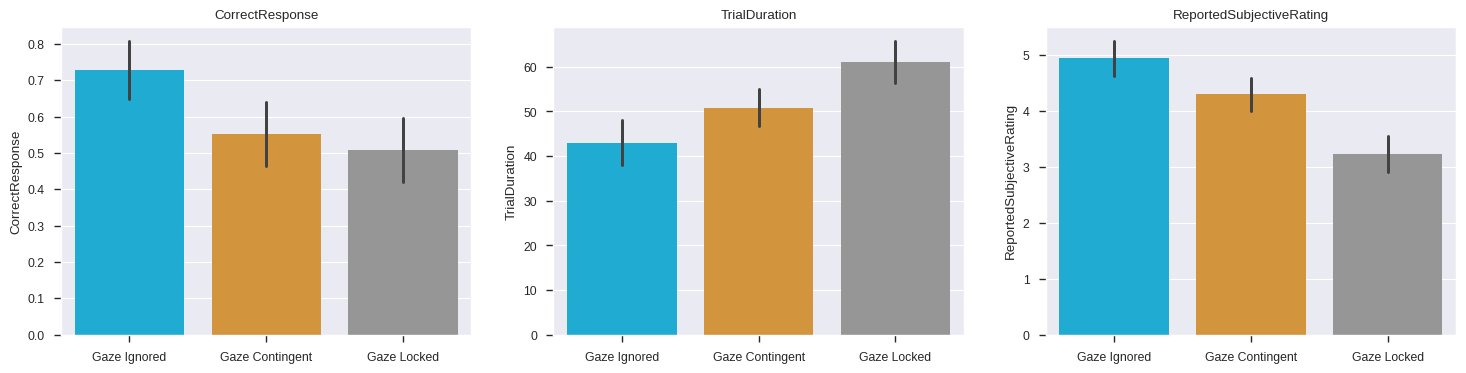

In [6]:
# Load the data used for plotting
data = pd.read_csv('out/scene_recognition_data.tsv', sep='\t')

# Previous observations and classification success as additional columns
data['SeenBeforeCount'] = data.groupby(['Subject', 'EnvironmentName']).cumcount()
data['CorrectResponse'] = (data.EnvironmentClass == data.ReportedRoomCategory).astype(float)

# Plot primary endpoints
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
visualization.set_figurestyle()
fig, axs = visualization.bar_plots(data, endpoints)
visualization.redefine_x_ticks(axs, remove_xlabel=True)

#### Averaged per subject

In [4]:
group = stats.GROUP # default: grouping by subject

In [5]:
# reindexed = data.set_index(['Subject','EnvironmentName'])
# first_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 0].copy()
# second_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 1].copy() #pun not intended
# before = first_sight.loc[second_sight.index]


# second_sight['GazeConditionBefore'] = before.GazeCondition
# second_sight['SameConditionBefore'] = before.GazeCondition == second_sight.GazeCondition
# second_sight['CorrectBefore'] = before.CorrectResponse
# second_sight['CorrectImprovement'] = before.CorrectResponse

# Save data used for plotting
# avg = stats.average(data,y=endpoints,group=group)
# # avg.to_csv(f'out/averaged_per_{group}.tsv', sep='\t', index=False)



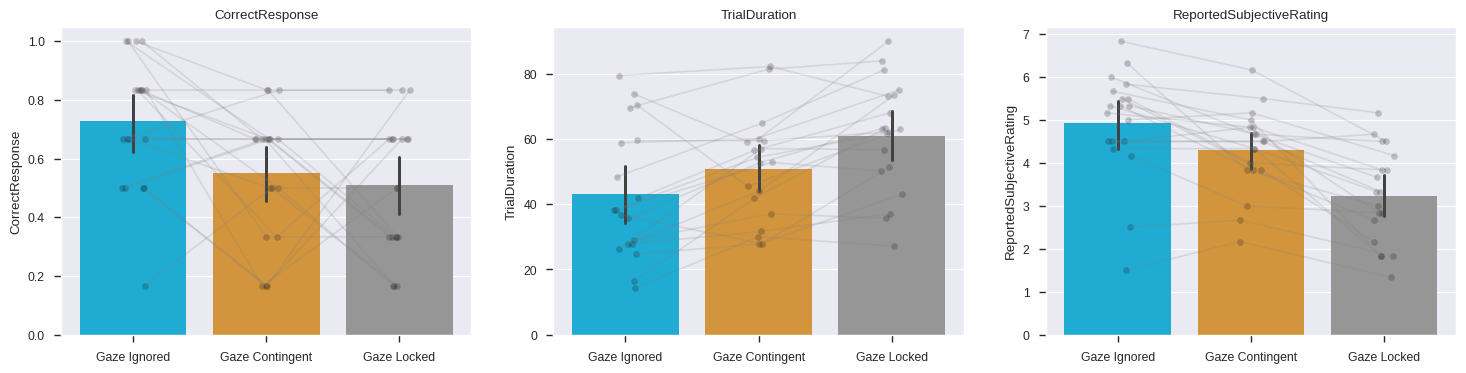

In [166]:
# Load data used for plotting
avg = pd.read_csv(f'out/averaged_per_{group}.tsv', sep='\t')

# Plot primary endpoints
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
visualization.set_figurestyle()
fig, axs = visualization.bar_plots(avg, endpoints)
visualization.swarm_plots(avg, endpoints, axs=axs, alpha =.2)
visualization.redefine_x_ticks(axs, remove_xlabel=True)
# visualization.add_significance_lines(axs[0], ('$\star$','$\star$'), #('$\star$', 'ns','$\star$'),
#                                      x_pairs = [(0, 1), (0,2)], #[(0, .95),  (1.05, 2), (0, 2)],
#                                      rel_y = [.83, .9]) #[.83, .83, .9] )
